<a href="https://colab.research.google.com/github/aswa09/EVA-4/blob/master/S5/EVA4_S5_F2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

#Train and Test Transforms(with Normalization)

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split(with Normalization)

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders

In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics(with Normalization)


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


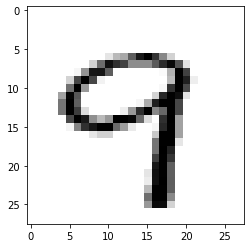

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


#Sample data

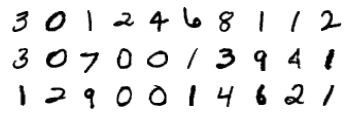

In [0]:
figure = plt.figure()
num_of_images = 30
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

#Base Model

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3, padding=0)   # input_size = 28 output_size = 26 receptive_field = 3
        self.conv2 = nn.Conv2d(10, 10, 3, padding=0)  # input_size = 26 output_size = 24 receptive_field = 5
        self.pool1 = nn.MaxPool2d(2, 2)               # input_size = 24 output_size = 12 receptive_field = 10
        self.conv3 = nn.Conv2d(10, 16, 3, padding=0)  # input_size = 12 output_size = 10 receptive_field = 12
        self.conv4 = nn.Conv2d(16,16, 3, padding=1)   # input_size = 10 output_size = 10 receptive_field = 14
        self.pool2 = nn.MaxPool2d(2, 2)               # input_size = 10 output_size = 5 receptive_field = 28
        self.conv5 = nn.Conv2d(16,16, 3,padding=1)    # input_size = 5 output_size = 5 receptive_field = 30
        self.conv6 = nn.Conv2d(16,10, 3)              # input_size = 5 output_size = 3 receptive_field = 32
        self.conv7 = nn.Conv2d(10,10,3)               # input_size = 3 output_size = 1 receptive_field = 34

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        
        x = self.conv7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params


In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
            Conv2d-2           [-1, 10, 24, 24]             910
         MaxPool2d-3           [-1, 10, 12, 12]               0
            Conv2d-4           [-1, 16, 10, 10]           1,456
            Conv2d-5           [-1, 16, 10, 10]           2,320
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Conv2d-7             [-1, 16, 5, 5]           2,320
            Conv2d-8             [-1, 10, 3, 3]           1,450
            Conv2d-9             [-1, 10, 1, 1]             910
Total params: 9,466
Trainable params: 9,466
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.14
Params size (MB): 0.04
Estimated Total Size (MB): 0.18
------------------------------------------

# Training and Testing

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

#Training and testing the model

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.046424224972724915 Batch_id=937 Accuracy=76.99: 100%|██████████| 938/938 [00:13<00:00, 69.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0903, Accuracy: 9710/10000 (97.10%)

EPOCH: 1


Loss=0.14866073429584503 Batch_id=937 Accuracy=97.31: 100%|██████████| 938/938 [00:13<00:00, 70.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0531, Accuracy: 9844/10000 (98.44%)

EPOCH: 2


Loss=0.0019974112510681152 Batch_id=937 Accuracy=98.17: 100%|██████████| 938/938 [00:13<00:00, 69.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0444, Accuracy: 9860/10000 (98.60%)

EPOCH: 3


Loss=0.3571636974811554 Batch_id=937 Accuracy=98.61: 100%|██████████| 938/938 [00:13<00:00, 69.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0423, Accuracy: 9863/10000 (98.63%)

EPOCH: 4


Loss=0.048311471939086914 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:13<00:00, 69.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0382, Accuracy: 9870/10000 (98.70%)

EPOCH: 5


Loss=0.014302104711532593 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:13<00:00, 69.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Accuracy: 9886/10000 (98.86%)

EPOCH: 6


Loss=0.0057333409786224365 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:13<00:00, 69.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9911/10000 (99.11%)

EPOCH: 7


Loss=0.01978905498981476 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [00:13<00:00, 70.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Accuracy: 9894/10000 (98.94%)

EPOCH: 8


Loss=0.0005431473255157471 Batch_id=937 Accuracy=99.22: 100%|██████████| 938/938 [00:15<00:00, 61.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9911/10000 (99.11%)

EPOCH: 9


Loss=0.09108363091945648 Batch_id=937 Accuracy=99.30: 100%|██████████| 938/938 [00:13<00:00, 67.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0417, Accuracy: 9870/10000 (98.70%)

EPOCH: 10


Loss=0.0012560337781906128 Batch_id=937 Accuracy=99.33: 100%|██████████| 938/938 [00:13<00:00, 69.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9900/10000 (99.00%)

EPOCH: 11


Loss=0.0735834538936615 Batch_id=937 Accuracy=99.38: 100%|██████████| 938/938 [00:13<00:00, 68.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9899/10000 (98.99%)

EPOCH: 12


Loss=0.00161665678024292 Batch_id=937 Accuracy=99.45: 100%|██████████| 938/938 [00:13<00:00, 69.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0390, Accuracy: 9895/10000 (98.95%)

EPOCH: 13


Loss=0.0019296109676361084 Batch_id=937 Accuracy=99.46: 100%|██████████| 938/938 [00:13<00:00, 69.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9914/10000 (99.14%)

EPOCH: 14


Loss=0.03125980496406555 Batch_id=937 Accuracy=99.48: 100%|██████████| 938/938 [00:13<00:00, 69.28it/s]



Test set: Average loss: 0.0385, Accuracy: 9890/10000 (98.90%)



Text(0.5, 1.0, 'Test Accuracy')

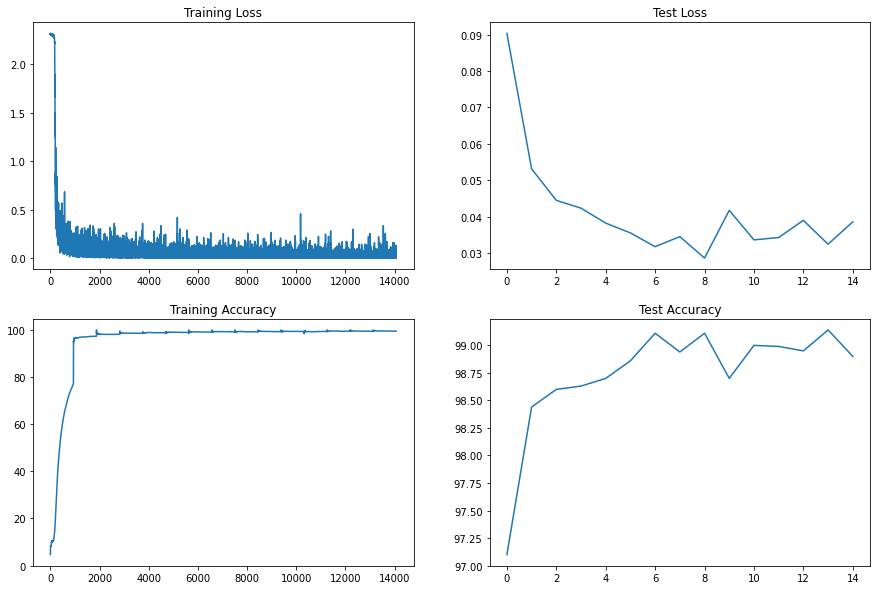

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")